### Make a copy of this note if you want to analyze 

#### Please run panta first to get gene clusters and other output files for this analysis

In [1]:
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import sys, re
from pangraph.utils import write_fasta
from networkx import NetworkXNoPath

In [2]:
def reverse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', '_':'_','*':'*'}
    # seq = "TCGGGCCC"
    reverse_complement = "".join(complement.get(base, base) for base in reversed(seq))
    return(reverse_complement)

In [3]:
def help_fnc(i, j):
    for ele in range(min(500,len(j)), -1, -1):
        if i.endswith(j[:ele]):
            print(ele, end =":")
            return j[ele:]
        
def overlap(a, b):
    test_list = [a, b]
    res = ''.join(help_fnc(i, j) for i, j in zip([''] + test_list, test_list))
    return(res)

In [4]:
overlap('AAAAAAAAABBAAAAAA', 'AAACCCCCCCCCCCCCCCCCCCCCC')

0:3:

'AAAAAAAAABBAAAAAACCCCCCCCCCCCCCCCCCCCCC'

In [5]:
# data_dir = "../panta/examples/test/output/"
# data_dir = "data/genome_graph_test/"
# you can take the data in the directory: data/genome_graph_test
# data_dir = "../panta/examples/test/output_Kp30plus1/"
data_dir = "../panta/examples/test/output_Kp100/"
# data_dir = "../panta/examples/test/output_Kp30mix_nosplitparalog/"
# data_dir = "../panta/examples/test/output_Kp500mix/"
# data_dir = "/data/hoan/amromics/simulation/art_output/spades_output/panta_output/"

In [6]:
sample_info = pd.read_csv(data_dir + "samples.tsv", delimiter='\t', header=None)
sample_info.columns = ['Name', 'SampleID']

In [7]:
sample_info.head(2)

,Name,SampleID
0,GCF_000220485.1_ASM22048v1_genomic,1
1,GCF_000785005.1_ASM78500v1_genomic,2


In [8]:
gene_info = pd.read_csv(data_dir + "gene_info.tsv", delimiter='\t', header=None)
gene_info.columns =['GeneName', 'SampleID', 'clusterID']

In [9]:
gene_info.head(2)

,GeneName,SampleID,clusterID
0,26_4971@924@-1,26,0
1,62_5071@924@1,62,0


In [10]:
# for i in range(5000):
#     print(sum(gene_info.clusterID==0), end =",")

In [11]:
gene_position = pd.read_csv(data_dir + 'gene_position.tsv', delimiter='\t', header=None)
gene_position.columns =['SampleID', 'ContigName', 'GeneSequence']

In [12]:
gene_position[gene_position.SampleID==0].head(2)

,SampleID,ContigName,GeneSequence
435,0,NODE_1_length_433075_cov_29.110519,0_1@378@1;0_2@1488@1;0_3@747@1;0_4@1275@1;0_5@...
436,0,NODE_2_length_329613_cov_29.003972,0_443@1164@-1;0_444@1425@1;0_445@2103@-1;0_446...


In [13]:
# print(gene_position.ContigName.values)

In [14]:
# gene_position.iloc[20:30,]

In [15]:
# sort by length of contigs
gene_position.sort_values(by="GeneSequence", key=lambda x: x.str.len(),  ascending=False, inplace=True)

In [16]:
print("List of all samples")
n_samples = len(np.unique(gene_position.iloc[:,0]))
np.unique(gene_position.iloc[:,0])

List of all samples


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

In [17]:
# ## select some sample
# selected_samples = [0, 32]
# sample_info = sample_info.loc[sample_info['SampleID'].isin(selected_samples)]
# gene_info = gene_info.loc[gene_info['SampleID'].isin(selected_samples)]
# gene_position = gene_position.loc[gene_position['SampleID'].isin(selected_samples)]

## Construct pangraph

In [21]:
%load_ext autoreload
%autoreload 2
from pangraph import PanGraph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# construct the pangenome graph
# min_contig_len = 100
pangraph = PanGraph(sample_info=sample_info, gene_info=gene_info, gene_position=gene_position)

In [24]:
incomplete_sample_name = "g1"
incomplete_sample_id = sample_info[sample_info.Name==incomplete_sample_name].iloc[0,1]
H = pangraph.construct_graph(method = "graph_alignment", sample_id_ref = None,  min_nucleotides = 90, min_genes = 0, 
                            target_genome_id=incomplete_sample_id) # use the same min_contig_len when generate the ground truth
# H = pangraph.construct_graph(method = "graph_alignment", sample_id_ref = 32,  min_nucleotides = 100, min_genes = 2) # use the same min_contig_len when generate the ground truth

Set minimum on number of nucleotides =  90 NUMBER OF COMPUTED CONTIGS: 490
Clip the matrix!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
(538332, 538332)


In [25]:
# nx.write_gml(H,'cytoscape_out/pan_graph.gml')

In [26]:
# number of nodes and edges
pangraph.n_clusters, H.number_of_edges()

(538332, 6657)

In [27]:
# pangraph.strand

## Data analysis

In [28]:
def append_strand(input_str):
    if input_str[-1]=="'":
        return (input_str[:-1] + '-')
    else:
        return (input_str + '+')

def append_strand_undirected(input_str):
    # print("Undirected!!!")
    if input_str[-1]=="'":
        return (input_str[:-1])
    else:
        return (input_str)

In [29]:
from pangraph.utils import getContigsAdjacency
edge_list_assembly = []
undirected_edge_list_assembly = []
# for l,r in getContigsAdjacency('/data/hoan/amromics/spades_quast/SAMN04158282/'):
for l,r in getContigsAdjacency('/data/hoan/amromics/simulation/art_output/spades_output_v2/'):
    # print("{} --> {}".format(l,r))
    edge_list_assembly.append((append_strand(l),append_strand(r)))
    # undirected_edge_list_assembly.append((append_strand_undirected(l), append_strand_undirected(r)))

assembly_graph= nx.DiGraph()
assembly_graph.add_edges_from(edge_list_assembly)
nx.write_gml(assembly_graph,'/data/hoan/amromics/simulation/art_output/spades_output_v2/assembly_graph.gml')

In [30]:
# edge_list_assembly

In [31]:
from pangraph.utils import buildOverlapEdge
from pangraph.utils import read_contigs2dict
gene = read_contigs2dict('/data/hoan/amromics/simulation/art_output/spades_output_v2/contigs.fasta')
# edge_list_overlap = buildOverlapEdge(gene, 20)
edge_list_overlap = buildOverlapEdge(gene, 20, 'directed')
# undirected_edge_list_overlap = buildOverlapEdge(gene, 20, 'undirected')

In [32]:
# edge_list_overlap

In [33]:
# print("Take union of two graph!!")
edge_list_final = edge_list_overlap + edge_list_assembly
# edge_list_final =  edge_list_assembly 
# undirected_edge_list_final =  undirected_edge_list_assembly + undirected_edge_list_overlap

In [34]:
# undirected_edge_list_final

In [35]:
assembly_graph= nx.DiGraph()
assembly_graph.add_edges_from(edge_list_final)
# undirected_assembly_graph= nx.Graph()
# undirected_assembly_graph.add_edges_from(undirected_edge_list_final)
nx.write_gml(assembly_graph,'/data/hoan/amromics/simulation/art_output/spades_output_v2/overlap_graph.gml')

In [36]:
# assembly_graph.has_edge('NODE_1_length_360583_cov_9.851928', 'NODE_2_length_327037_cov_9.679695')

In [37]:
# graph_use = undirected_assembly_graph if graph_type=='undirected' else assembly_graph
# method = weight_path_assembly: less contigs, more strict condition on adding two nodes
# maximum_matching = (greedy, opt), opt: optimal 
params = {'method': 'weight_path_assembly_v2', 'assembly_graph': assembly_graph, 'max_length': 5, 'maximum_matching': 'opt', 'graph':'directed'}
# params = {'method': 'weight_path_assembly_v2', 'assembly_graph': graph_use, 'max_length': 5, 'maximum_matching': 'greedy', 'graph':'directed'}

In [38]:
# nx.is_directed(graph_use)

In [39]:
# contig_graph = pangraph.join_contig(sample_id=incomplete_sample_id, min_weight=1.0, method="edge_weight")
# contig_graph = pangraph.join_contig(sample_id=incomplete_sample_id, min_weight=1.0, method="weight_path")
# contig_graph = pangraph.remove_cycle(assembly_graph)
# contig_graph = pangraph.join_contig(sample_id=incomplete_sample_id, min_weight=1.0, method="weight_path_assembly", assembly_graph=assembly_graph, max_length=5)
contig_graph = pangraph.join_contig(sample_id=incomplete_sample_id, min_weight=1.0, params=params)
contig_graph = pangraph.remove_cycle(assembly_graph)
nx.write_gml(contig_graph,'cytoscape_out/contig_graph.gml')
nx.write_gml(contig_graph,'/data/hoan/amromics/simulation/art_output/spades_output_v2/contig_graph.gml')

Compute maximum matching


In [40]:
incomplete_sample_id

0

In [41]:
list(nx.simple_cycles(contig_graph))

[]

In [42]:
contig_graph.number_of_nodes()

47

In [43]:
# assembly_graph.has_edge('NODE_64_length_2789_cov_78.536504-', 'NODE_15_length_117021_cov_9.593267+')


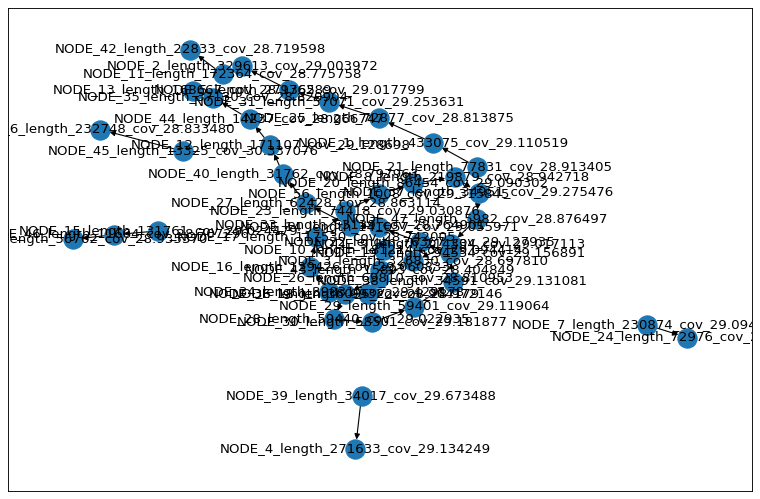

In [44]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)
nx.draw_networkx(contig_graph, arrows=True)

In [45]:
indegree_dict = dict(contig_graph.in_degree())
# indegree_dict

In [46]:
adj_list = {}
for source_node_key in indegree_dict:
    if indegree_dict[source_node_key] == 0:
        adj_list[source_node_key] = []
        next_neighbor_temp = source_node_key
        while(1):
            next_neighbor_temp = list(contig_graph.neighbors(next_neighbor_temp))
            if len(next_neighbor_temp) > 0:
                next_neighbor_temp = next_neighbor_temp[0]
                adj_list[source_node_key].append(next_neighbor_temp)
            else:
                break;

In [47]:
# adj_list

In [48]:
# list(gene_position.ContigName)

In [49]:
# pangraph.gene2cluster_dict['FHLJBAOL_00001_0_1@390@+']

In [50]:
def flatten(l):
    if len(l) == 1:
        return l[0]
    else:
        return [item for sublist in l for item in sublist]
def remove_duplicate(your_list):
    return ([v for i, v in enumerate(your_list) if i == 0 or v != your_list[i-1]])

In [51]:
## neu ko la adjacent thi bat dau bang contigs moi.
adj_list_assembly = {}
for key in adj_list:
    new_key = key
    path1 = adj_list[key].copy()
    path1.insert(0, key)
    path2 = [new_key + pangraph.strand[new_key]]
    for i in range(len(path1)-1):
        src = path1[i] + pangraph.strand[path1[i]]
        dst = path1[i+1] + pangraph.strand[path1[i+1]]
        if not assembly_graph.has_node(src):
            path2.append(src)
        elif not assembly_graph.has_node(dst):
            path2.append(src)
            continue
        else:
            # print("Hi, I am here")
            if nx.has_path(assembly_graph, src, dst):
                paths = [p for p in nx.all_shortest_paths(assembly_graph, src, dst)]
                # print(src, dst,"___", paths[0])  
                for node in paths[0]:
                    path2.append(node)
            else:
                # print(src, dst,"___", paths[0])    
                path2.append(src)
                
                print("Will test this, Ok?")
                # # construct a new path if they are disconnected on the graph
                # if len(path2) > 0:
                #     adj_list_assembly[new_key+pangraph.strand[new_key]] = remove_duplicate(path2)
                # new_key = dst[0:-1]
                # path2 = []           
    if dst not in path2:
        # print(path2)
        path2.append(dst)
    if len(path2) > 0:
        adj_list_assembly[new_key+pangraph.strand[new_key]] = remove_duplicate(path2)

Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?


In [52]:
# adj_list

In [53]:
# adj_list_assembly
for key in adj_list_assembly:
    for elem in adj_list_assembly[key]:
        print(elem[5:8], end='')
        print(elem[-1], end=',')
    print('\n')

7_l-,24_+,

21_+,52_+,1_l-,25_+,156+,147-,31_-,5_l-,50_+,2_l+,11_+,42_-,

10_-,43_-,18_-,34_-,16_-,53_-,17_-,149-,23_-,56_+,20_-,8_l+,52_+,37_+,47_-,9_l+,54_-,3_l-,26_-,53_-,15_+,54_-,36_-,53_-,28_-,30_+,29_+,71_+,165+,38_-,19_+,50_-,22_-,14_-,33_-,52_-,27_+,50_-,40_-,12_+,50_-,44_-,35_+,183+,13_-,

15_-,53_+,46_+,32_-,

45_-,6_l+,

39_+,4_l-,



In [54]:
## Keep all contigs
gene_origin = gene.copy()
# adj_list = {}
for key in adj_list_assembly:
    path = adj_list_assembly[key]
    if len(path) > 1:
        source_node_key = key[:-1]
        if key[-1]=='-':
            gene_origin[source_node_key] = reverse_complement(gene[source_node_key])

        if source_node_key not in gene_origin:
            gene_origin[source_node_key] = gene[source_node_key]
            
        for i in range(1, len(path)):
            # print(next_neighbor_temp)
            next_neighbor_temp = path[i][:-1]
            strand = path[i][-1]
            if strand == '+':
                # print(source_node_key)
                gene_origin[source_node_key] = gene_origin[source_node_key]+gene[next_neighbor_temp]
                # gene_origin[source_node_key] = overlap(gene_origin[source_node_key], gene[next_neighbor_temp])
            else:
                gene_origin[source_node_key] = gene_origin[source_node_key]+reverse_complement(gene[next_neighbor_temp])
                # gene_origin[source_node_key] = overlap(gene_origin[source_node_key], reverse_complement(gene[next_neighbor_temp]))
            if next_neighbor_temp in gene_origin:
                del gene_origin[next_neighbor_temp]

In [55]:
# ### Only the assembled contigs
# gene_origin = {}
# for key in adj_list_assembly:
#     path = adj_list_assembly[key]
#     if len(path) > 1:
#         source_node_key = key[:-1]
#         if key[-1]=='-':
#             gene_origin[source_node_key] = reverse_complement(gene[source_node_key])
#         else:
#             gene_origin[source_node_key] = gene[source_node_key]
            
#         for i in range(1, len(path)):
#             # print(next_neighbor_temp)
#             next_neighbor_temp = path[i][:-1]
#             strand = path[i][-1]
#             if strand == '+':
#                 # print(source_node_key)
#                 gene_origin[source_node_key] = gene_origin[source_node_key]+gene[next_neighbor_temp]
#                 # gene_origin[source_node_key] = overlap(gene_origin[source_node_key], gene[next_neighbor_temp])
#             else:
#                 gene_origin[source_node_key] = gene_origin[source_node_key]+reverse_complement(gene[next_neighbor_temp])
#                 # gene_origin[source_node_key] = overlap(gene_origin[source_node_key], reverse_complement(gene[next_neighbor_temp]))

In [56]:
# write_fasta(gene_origin, "/data/hoan/amromics/simulation/art_output/spades_output/contigs_concat_weight_path.fasta")
# write_fasta(gene_origin, "/data/hoan/amromics/simulation/art_output/spades_output/contigs_concat.fasta")
write_fasta(gene_origin, "/data/hoan/amromics/simulation/art_output/spades_output_v2/contigs_concat.fasta")

Success! File written


In [57]:
# import os
# os.system('source /data/hoan/amromics/simulation/binquast.sh')

## Manual contigs

In [58]:
# adj_list_assembly_new = adj_list_assembly.copy()

In [59]:
# del adj_list_assembly_new['NODE_44_length_34028_cov_10.186887-'] # ko tac dung
# del adj_list_assembly_new['NODE_5_length_216832_cov_9.725077+'] # ok
# del adj_list_assembly_new['NODE_43_length_34423_cov_9.752082-'] # ko tac dung
# del adj_list_assembly_new['NODE_4_length_232574_cov_9.604416+'] #ok
# del adj_list_assembly_new['NODE_25_length_72920_cov_9.686833+'] # ko tac dung
# del adj_list_assembly_new['NODE_25_length_72920_cov_9.686833+'] # ko tac dung
# del adj_list_assembly_new['NODE_31_length_59606_cov_9.576055+'] #

In [60]:
# gene_origin = gene.copy()
# # adj_list = {}
# for key in adj_list_assembly_new:
#     path = adj_list_assembly_new[key]
#     if len(path) > 1:
#         source_node_key = key[:-1]
#         if key[-1]=='-':
#             gene_origin[source_node_key] = reverse_complement(gene_origin[source_node_key])
#         print("\n", source_node_key)
#         for i in range(1, len(path)):
#             # print(next_neighbor_temp)
#             next_neighbor_temp = path[i][:-1]
#             strand = path[i][-1]
#             if strand == '+':
#                 # gene_origin[source_node_key] = gene_origin[source_node_key]+gene[next_neighbor_temp]
#                 gene_origin[source_node_key] = overlap(gene_origin[source_node_key], gene[next_neighbor_temp])
#             else:
#                 # gene_origin[source_node_key] = gene_origin[source_node_key]+reverse_complement(gene[next_neighbor_temp])
#                 gene_origin[source_node_key] = overlap(gene_origin[source_node_key], reverse_complement(gene[next_neighbor_temp]))
#             print("->", end = ",")
#             if next_neighbor_temp in gene_origin:
#                 del gene_origin[next_neighbor_temp]

In [61]:
# # write_fasta(gene_origin, "/data/hoan/amromics/simulation/art_output/spades_output/contigs_concat_weight_path.fasta")
# write_fasta(gene_origin, "/data/hoan/amromics/simulation/art_output/spades_output/contigs_concat_modify.fasta")

In [62]:
# adj_list_assembly_new

In [63]:
# gene2 = {}
# gene2['NODE_31_length_59606_cov_9.576055'] = gene['NODE_31_length_59606_cov_9.576055']
# gene2['NODE_35_length_57882_cov_9.856258'] = gene['NODE_35_length_57882_cov_9.856258']
# write_fasta(gene2, "/data/hoan/amromics/simulation/art_output/spades_output/contigs_3135.fasta")

In [64]:
### Chay maximum matching, 100 mau random, complete. Chay medusa
## Chon mau khac voi refererences.

In [65]:
## send assembly and reference to Dr. Duc

### Quast 

In [66]:
import os

In [ ]:
os.system('python /data/hoan/amromics/spades_quast/quast-5.2.0/quast.py /data/hoan/amromics/simulation/art_output/spades_output_v2/contigs_concat.fasta -l GR_overlap -r /data/hoan/amromics/simulation/references/GCF_000240185.1_ASM24018v2_genomic.fasta -o /data/hoan/amromics/simulation/art_output/spades_output_v2/quastResults_Kp100_pangraph --silent --extensive-mis-size 5000')

/data/hoan/amromics/spades_quast/quast-5.2.0/quast.py /data/hoan/amromics/simulation/art_output/spades_output_v2/contigs_concat.fasta -l GR_overlap -r /data/hoan/amromics/simulation/references/GCF_000240185.1_ASM24018v2_genomic.fasta -o /data/hoan/amromics/simulation/art_output/spades_output_v2/quastResults_Kp100_pangraph --silent --extensive-mis-size 5000


System information:
  OS: Linux-3.10.0-1160.15.2.el7.x86_64-x86_64-with-redhat-7.9-Nitrogen (linux_64)
  Python version: 2.7.5
  CPUs number: 72

Started: 2022-11-28 07:36:59

Logging to /data/hoan/amromics/simulation/art_output/spades_output_v2/quastResults_Kp100_pangraph/quast.log
NOTICE: Output directory already exists and looks like a QUAST output dir. Existing results can be reused (e.g. previously generated alignments)!
NOTICE: Maximum number of threads is set to 18 (use --threads option to set it manually)

CWD: /data/hoan/amromics/genome-graph
Main parameters: 
  MODE: default, threads: 18, min contig length: 500, min align